In [1]:
import numpy as np
import numpy.ma as ma
import os
import scipy.optimize as op
from scipy import stats
from scipy.optimize import curve_fit

from astropy.io import fits
from astropy.table import Table, Column, MaskedColumn,unique
from astropy.io import ascii
from astropy.table import QTable,vstack
from astropy import units as u

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import PercentFormatter
import matplotlib.patches as mpatches

from mangadap.config import defaults

import posixpath
import numpy.ma as ma
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from beta_corr import CubeData


plt.rcParams['figure.figsize'] = (10,6)
plt.rc('axes', labelsize = 25)
plt.rc('axes', titlesize = 18)
#plt.rc('axes', titleweight = 'bold')
plt.rc('axes', lw = 2)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 8
plt.rcParams['ytick.minor.size'] = 8

# Applying the Correlation Correction 

In [2]:
class CubeData:

    def __init__(self,galname=None,bin_key=None,plate=None,ifu=None):
        # mangadap_muse root directory path
        mangadap_muse_dir = posixpath.dirname(globals()['_dh'][0])
        # output directory path 
        output_root_dir = os.path.join(mangadap_muse_dir,'outputs')
        
        self.galname = galname
        output_gal_dir = os.path.join(output_root_dir,f"{self.galname}-{bin_key}")
        
        # output beta plot directory
        output_beta_dir = os.path.join(output_gal_dir,'beta_plots')
        if not os.path.isdir(output_beta_dir):
            os.makedirs(output_beta_dir)
        self.output_beta_dir = output_beta_dir

        
        beta_hist_dir = os.path.join(output_beta_dir,'beta_histogram_plots')
        # non-corrected MUSE cube directory
        output_gal_sub_dir = os.path.join(output_gal_dir, 'NO-CORR')
        # key methdos from analysis plan
        analysisplan_methods = 'MILESHC-MASTARHC2-NOISM'
        # cube directory
        cube_dir =os.path.join(output_gal_sub_dir,f"{bin_key}-{analysisplan_methods}",plate,ifu)
        # paths to the LOGCUBE and MAPS files
        cube_file_path = os.path.join(cube_dir,
                                      f"manga-{plate}-{ifu}-LOGCUBE-{bin_key}-{analysisplan_methods}.fits")
        maps_file_path = os.path.join(cube_dir,
                                      f"manga-{plate}-{ifu}-MAPS-{bin_key}-{analysisplan_methods}.fits")
        cube = fits.open(cube_file_path)
        maps = fits.open(maps_file_path)
        # bin ID has multiple layers of the same bin id map so use first one        
        self.binid_map =  maps['BINID'].data[0]
        # obtain wavelength, flux, model and error array from MUSE cube
        self.wave = cube['WAVE'].data
        self.flux = cube['FLUX'].data
        self.model = cube['MODEL'].data
        self.error = np.sqrt(1/cube['IVAR'].data)
    
    
    def SN_dict(self):
        # create a dictionary containing that stores the number of spaxels in each bin ID
        # and beta values for each S/N bin
        SN_dict = {}
        SN_channel_keys = ['SN_range','bin_size','beta_bin']

        SN_lims = [[0,50],[50,75],[75,100],[100,1000]]

        for i in range(len(SN_lims)):
            channel = f'SN_CHANNEL{i}'
            SN_dict[channel] = {}

            for key in SN_channel_keys:
                if key == 'SN_range':
                    SN_dict[channel][key] = SN_lims[i]
                else:
                    SN_dict[channel][key] = None   
                    
        return SN_dict
    
    def N_spx_dict(self):
        # create a dictionary containing the different N_spx bins
        N_spx_dict = {}
        N_spx_channel_keys = ['N_spx_range','SN_dict']

        N_spx_lims = [[0,5.5],[5.5,22],[22,52],[52,122]]

        for i in range(len(N_spx_lims)):
            channel = f'N_spx_CHANNEL{i}'
            N_spx_dict[channel] = {}

            for key in N_spx_channel_keys:
                if key == 'N_spx_range':
                    N_spx_dict[channel][key] = N_spx_lims[i]
                # add S/N dictionary
                if key == 'SN_dict':
                    N_spx_dict[channel][key] = self.SN_dict()
                    
        return N_spx_dict
    
    def Beta_all_dict(self):
        # create a dictionary containing the different N_spx bins
        Beta_all_dict = {}
        Beta_all_channel_keys = ['SN_range','bin_size_all','beta_all','bin_modes','beta_medians']

        SN_lims = [[0,50],[50,75],[75,100],[100,1000]]

        for i in range(len(SN_lims)):
            channel = f'SN_CHANNEL{i}'
            Beta_all_dict[channel] = {}

            for key in Beta_all_channel_keys:
                if key == 'SN_range':
                    Beta_all_dict[channel][key] = SN_lims[i]
                    
                elif (key == 'bin_size_all') or (key == 'beta_all'):
                    Beta_all_dict[channel][key] = []
                    
                else:
                    Beta_all_dict[channel][key] = []
                    
        return Beta_all_dict
    
    def wv_dict(self):
        # create a dictionary for each wavelength channel        
        wv_dict = {}
        wv_channel_keys = ['wv_range','bin_masks','N_spx','SN','beta','N_spx_dict','Beta_all_dict']

        # wavelength ranges
        wv_lims = [[4751.42,5212],[5212,5672],[5672,6132],[6132,6592],
          [6592,7052],[7052,7513],[7513,7973],[7973,8433],[8433,8893],[8893,9353.44]]

        for i in range(len(wv_lims)):
            channel = f'WAVE_CHANNEL{i}'
            wv_dict[channel] = {}

            for key in wv_channel_keys:
                if key == 'wv_range':
                    wv_dict[channel][key] = wv_lims[i]
                # add N_spx dictionary
                elif key == 'N_spx_dict':
                    wv_dict[channel][key] = self.N_spx_dict()
                # add Beta_all dictionary
                elif key == 'Beta_all_dict':
                    wv_dict[channel][key] = self.Beta_all_dict()
                else:
                    wv_dict[channel][key] = None
                    
        return wv_dict
    
    
    def filter_data(self,array,conditional_array,lim):
        # filter out the input array based on the conditional array and input limits      
        return array[(conditional_array >= lim[0]) & (conditional_array <=  lim[1])] 
    
    
    def apply_mask(self,wave_bin,flux_bin,model_bin,error_bin):
        # mask for large unaccounted emission or absorption lines if present

        # calculate the standard deviation in the fit residuals (rN)
        # https://quantifyinghealth.com/residual-standard-deviation-error/ for reference
        rN_1sigma = np.sqrt( np.mean( (flux_bin - model_bin)**2 ) )
        # calculate rN per pixel
        rN = np.sqrt( (flux_bin - model_bin)**2 )

        # perform a rudimentary sigma clip and
        # mask indices where the residual noise exceeds 10 sigma
        wave_mask = ma.masked_where(rN/rN_1sigma >= 10, wave_bin)
        flux_mask = ma.masked_where(rN/rN_1sigma >= 10, flux_bin)
        model_mask = ma.masked_where(rN/rN_1sigma >= 10, model_bin)
        error_mask = ma.masked_where(rN/rN_1sigma >= 10, error_bin)

        return wave_mask,flux_mask, model_mask, error_mask
        
    def calc_beta(self,wave,flux,model,error,binid_map):
        # calculate number of spaxels, S/N and correlation ratio value for each bin ID
        
        # total number of bins
        n_bins = np.max(binid_map)+1
        
        bin_masks = []
        bin_sizes = np.zeros(n_bins)
        sn = np.zeros(n_bins)
        betas = np.zeros(n_bins)

        for i in range(n_bins):
            id_mask = binid_map == i
            # get bin sizes, S/N and beta value for each bin ID
            n_spx = len(flux[:,id_mask][0,:])
            # get flux, stellar continuum model and variance array from bin ID
            #print(flux)
            flux_bin = flux[:,id_mask][:,0]
            model_bin = model[:,id_mask][:,0]
            error_bin = error[:,id_mask][:,0]
            
            # mask values
            wave_mask,flux_mask,model_mask,error_mask = self.apply_mask(wave,flux_bin,model_bin,
                                                                        error_bin)
            
            # calculate the S/N and correlation ratio with the masked data
            snr = np.median(flux_mask/error_mask)
            # calculate the standard deviation in the fit residuals (rN)
            rN_1sigma = np.sqrt( np.mean( (flux_mask - model_mask)**2 ) )
            # calculate the correlation ratio (between residual noise 
            # and propagated noise (beta = rN/N) 
            beta = (rN_1sigma/np.median(error_mask))

            # don't store correlation ratio if its non-finite and less than 0
            if (np.isfinite(beta)==False) or (beta<0):
                continue
            else:
                bin_masks.append(flux_mask.mask)
                bin_sizes[i] = n_spx
                sn[i] = snr
                betas[i] = beta 

        return bin_masks, bin_sizes, sn, betas
    

    def get_beta(self):
        # dictionary for each wavelength channel
        self.wv_dict = self.wv_dict()
    
        for wv_key in self.wv_dict.keys():
            # filter data
            #wave_filt, flux_filt, model_filt, err_filt = self.filter_data(self.wv_dict[key]['wv_range'])
            wave_filt = self.filter_data(self.wave,self.wave,self.wv_dict[wv_key]['wv_range'])
            flux_filt = self.filter_data(self.flux,self.wave,self.wv_dict[wv_key]['wv_range'])
            model_filt = self.filter_data(self.model,self.wave,self.wv_dict[wv_key]['wv_range'])
            err_filt = self.filter_data(self.error,self.wave,self.wv_dict[wv_key]['wv_range'])
            
            # get number of spaxels in each bin, S/N and beta value for each bin ID
            bin_masks, bin_sizes,sn,betas = self.calc_beta(wave_filt,flux_filt,
                                                          model_filt,err_filt,self.binid_map)
            # save the mask from each bin ID
            self.wv_dict[wv_key]['bin_masks'] = bin_masks
            
            # loop through and place each spaxel bin size and beta value into their respective 
            # N_spx and S/N bin
            N_spx_dict = self.wv_dict[wv_key]['N_spx_dict']
            Beta_all_dict = self.wv_dict[wv_key]['Beta_all_dict']
            
            for N_spx_key in N_spx_dict.keys():
                # filter bin size, S/N and beta values according to number of spaxel (N_spx) range
                bin_sizes_N_spx_filt = self.filter_data(bin_sizes,
                                                        bin_sizes,N_spx_dict[N_spx_key]['N_spx_range'])
                sn_N_spx_filt        =  self.filter_data(sn,
                                                        bin_sizes,N_spx_dict[N_spx_key]['N_spx_range'])
                beta_N_spx_filt      =  self.filter_data(betas,
                                                        bin_sizes,N_spx_dict[N_spx_key]['N_spx_range'])

                SN_dict = N_spx_dict[N_spx_key]['SN_dict']
                for SN_key in SN_dict.keys():
                    # filter bin size and beta values according to S/N range
                    bin_size_SN_filt = self.filter_data(bin_sizes_N_spx_filt,
                                                        sn_N_spx_filt,SN_dict[SN_key]['SN_range'])
                    beta_SN_filt = self.filter_data(beta_N_spx_filt,
                                                    sn_N_spx_filt,SN_dict[SN_key]['SN_range'])
                    # save the data 
                    SN_dict[SN_key]['bin_size'] = bin_size_SN_filt
                    SN_dict[SN_key]['beta_bin'] = beta_SN_filt
                    
                N_spx_dict[N_spx_key]['SN_dict'] = SN_dict
                
            for all_key in Beta_all_dict.keys():
                for N_spx_key in N_spx_dict.keys():
                    bin_size = N_spx_dict[N_spx_key]['SN_dict'][all_key]['bin_size']
                    beta_bin = N_spx_dict[N_spx_key]['SN_dict'][all_key]['beta_bin']
                    
                    Beta_all_dict[all_key]['bin_size_all'].append(bin_size)
                    Beta_all_dict[all_key]['beta_all'].append(beta_bin)
                    
            for all_key in Beta_all_dict.keys():
                bin_size_all = Beta_all_dict[all_key]['bin_size_all']
                beta_all = Beta_all_dict[all_key]['beta_all']
                
                for bin_array,beta_array in zip(bin_size_all,beta_all):
                    if len(bin_array) == 0:
                        Beta_all_dict[all_key]['bin_modes'].append(-999)
                        Beta_all_dict[all_key]['beta_medians'].append(-999)
                        
                    else:
                        Beta_all_dict[all_key]['bin_modes'].append(stats.mode(bin_array)[0])
                        Beta_all_dict[all_key]['beta_medians'].append(np.median(beta_array))

            self.wv_dict[wv_key]['N_spx_dict'] = N_spx_dict
            self.wv_dict[wv_key]['Beta_all_dict'] = Beta_all_dict
        

            
    def write_beta_tables(self):
        
        def beta_func_quad(self,N_spx,a,b):
            return 1 + a*(np.log10(N_spx))**b
        
        # dictionary for each wavelength channel
        wv_dict = self.wv_dict
                        
        for wv_key in wv_dict.keys():
            # dictionary for each wavelength channel
            wv_lim = wv_dict[wv_key]['wv_range']
            Beta_all_dict = wv_dict[wv_key]['Beta_all_dict']
            
            # list to store median beta values to write into .dat file
            beta_table_data = []
            
            # list to store values for plotting
            bin_all = []
            beta_all = []
            
            # list to store for values for fitting Sarzi+2018 relation
            bin_fit = []
            beta_fit = []
            
            # loop through each S/N channel within Beta_all dicitonary
            for all_key in Beta_all_dict.keys():
                bin_modes = Beta_all_dict[all_key]['bin_modes']
                beta_medians = Beta_all_dict[all_key]['beta_medians']
                
                # don't keep last beta median value because the correlation 
                # correction does not do well for N_spx > 100
                beta_table_data.append(beta_medians[:3])

                for bin_mode,beta_median in zip(bin_modes,beta_medians):
                    bin_all.append(bin_mode)
                    beta_all.append(beta_median)
        
                    if bin_mode == -999:
                        continue
                    else:
                        bin_fit.append(bin_mode)
                        beta_fit.append(beta_median)

            # get parameters
            # fit data points usings Sarzi+2018 relationshiop
            popt_sarzi, pcov_sarzi = curve_fit(beta_func_quad, bin_fit, beta_fit)

            # create data table containting each median beta histogram distribution 
            # for a given S/N and N_spax size
            beta_T = Table([beta_table_data[0],beta_table_data[1],beta_table_data[2],
                                [popt_sarzi[0],-999,-999],[popt_sarzi[1],-999,-999]],
                          names=('S_N_0-50','S_N_50-75','S_N_75-100','param_fit_a','param_fit_b'))

            # create the beta table directory
            beta_tables_dir = os.path.join(defaults.dap_data_root(),'beta_tables')
            beta_tables_gal_dir = os.path.join(beta_tables_dir,cube.galname)
            if not os.path.isdir(beta_tables_gal_dir):
                        os.makedirs(beta_tables_gal_dir)

            # create the file name
            file_name = f'beta_corr_{wv_lim[0]}_{wv_lim[1]}.dat'
            beta_table_path = os.path.join(beta_tables_gal_dir,file_name)
            beta_T.write(beta_table_path, format='ascii', overwrite=True)  
            
            
            
    def mk_residual_plot(self,wv_channel,bin_id,zoom=None):
        # plot the flux, model and error in main plot
        # lower plot showcases the ratio between the residual-noise-per-pixel and
        # 1 standard deviation of the residual noise over the entire wavelength channel (rN/1sigma_rN)
        
        # wavelength channel dictionary
        wv_dict = self.wv_dict[f'WAVE_CHANNEL{wv_channel}']
        # mask array
        mask_bin = wv_dict['bin_masks'][bin_id]

        wave_bin = self.wave
        # get flux, stellar continuum model and variance array from bin ID
        id_mask = self.binid_map == bin_id
        flux_bin = self.flux[:,id_mask][:,0]
        model_bin = self.model[:,id_mask][:,0]
        error_bin = self.error[:,id_mask][:,0]
        
        # filter out data and apply mask from bin ID 
        wave = ma.masked_array(self.filter_data(wave_bin,wave_bin,wv_dict['wv_range']), mask=mask_bin) 
        flux = ma.masked_array(self.filter_data(flux_bin,wave_bin,wv_dict['wv_range']), mask=mask_bin) 
        model = ma.masked_array(self.filter_data(model_bin,wave_bin,wv_dict['wv_range']), mask=mask_bin)
        err = ma.masked_array(self.filter_data(error_bin,wave_bin,wv_dict['wv_range']), mask=mask_bin)

        # 1 sigma residual noise before and afer being masked
        rN_1sigma_unmasked = np.sqrt( np.mean( (flux.data - model.data)**2 ) )
        rN_1sigma_masked = np.sqrt( np.mean( (flux - model)**2 ) )
        
        # show good and bad beta values per pixel before being masked 
        beta_good_unmasked = rN_1sigma_unmasked/err
        beta_bad_unmasked = rN_1sigma_unmasked/err.data
        
        # show beta values after being masked
        beta_good_masked = rN_1sigma_masked/err.data

        # make plots
        fig = plt.figure(figsize=(10,6))
        #plt.rcParams['figure.figsize'] = (10,6)
        
        # create an extra masked plot if there are masked pixels
        if flux.mask.any()==True:
            gs = fig.add_gridspec(3, hspace=0,height_ratios=(3,1,1))
            axs = gs.subplots(sharex=True)
        else:
            gs = fig.add_gridspec(2, hspace=0,height_ratios=(3,1))
            axs = gs.subplots(sharex=True)
            
        axs[0].set_title(f'Wavelength Channel {wv_channel} ({wv_dict["wv_range"][0]}-' 
                     f'{wv_dict["wv_range"][1]} $\mathrm{{\AA}}$)',fontsize=22)
            
        axs[0].step(wave.data,flux.data,c='k',zorder=2,label='Data')
        axs[0].step(wave.data,model.data,c='tab:purple',zorder=3, label='Model')
        axs[0].step(wave.data,err.data,c='tab:green',zorder=1,label='Error')
        axs[0].set_ylabel(r'Flux ($10^{-20} \mathrm{erg}$ $\mathrm{cm}^{-2}$ $\mathrm{s}^{-1}$)',fontsize=19)
        axs[0].set_ylim(-0.01,np.median(flux)*1.25)
               
        if flux.mask.any()==True:
            
            # manually define a patch for the masked region
            ax0_handles, labels = axs[0].get_legend_handles_labels()
            mask_patch = mpatches.Patch(color='cadetblue', label='Masked Region',alpha=0.3)
            # append manual patch
            ax0_handles.append(mask_patch)
            axs[0].legend(handles=ax0_handles,fontsize='large',loc='center left')
            
            # plot beta values before being maksed
            axs[1].step(wave,beta_good_unmasked,
                        label=r'$\beta$ Before Masking',c='grey',zorder=2)
            # plot bad beta values
            axs[1].step(wave.data,beta_bad_unmasked,
                        label=r'Masked Pixels',c='r',zorder=1)
            
            axs[1].set_ylabel(r'$\beta$',fontsize = 20)
            axs[1].set_ylim(-0.5,np.median(beta_good_unmasked)*2.2)
            axs[1].legend(fontsize='large',frameon=False,loc='upper left',ncol=2)
                        
            # plot beta values after being masked
            axs[2].step(wave.data,beta_good_masked,
                        label=r'$\beta$ After Masking',c='grey',zorder=1)
            
            axs[2].set_xlabel(r'Wavelength ($\mathrm{\AA}$)',fontsize = 20)
            axs[2].set_ylabel(r'$\beta$',fontsize = 20)
            axs[2].set_ylim(-0.5,np.median(beta_good_unmasked)*2.2)
            axs[2].legend(fontsize='large',frameon=False,loc='upper left')
            
            # highlight masked regions
            pix_size = wave.data[1]-wave.data[0]
            for masked_pix in wave.data[wave.mask]:
                axs[0].axvspan(masked_pix-(pix_size/1),masked_pix,alpha=0.3, 
                               color='cadetblue',zorder=4)
                axs[1].axvspan(masked_pix-(pix_size/1),masked_pix,alpha=0.3, 
                               color='cadetblue',zorder=4)
                axs[2].axvspan(masked_pix-(pix_size/1),masked_pix,alpha=0.3, 
                               color='cadetblue',zorder=4)
            
            if zoom is not None:
                axs[0].set_xlim(zoom[0],zoom[1])
                axs[1].set_xlim(zoom[0],zoom[1])
                axs[2].set_xlim(zoom[0],zoom[1])

        else:
            # only create one beta plot if theres no masking
            logging.info('No masked pixels!')
            
            # create legend without masked region patch
            axs[0].legend(fontsize='large',loc='center left')
            
            # plot beta values before being maksed
            axs[1].step(wave,beta_good_masked,c='grey',zorder=1)
            
            axs[1].set_xlabel(r'Wavelength ($\mathrm{\AA}$)',fontsize = 20)
            axs[1].set_ylabel(r'$\beta$',fontsize = 20)
            axs[1].set_ylim(-0.5,np.median(beta_good_masked)*2.2);
            #axs[1].legend(fontsize='large',frameon=False,loc='upper left');
            
            # zoom must be a list with two wavelegnth values in it
            if zoom is not None:
                axs[0].set_xlim(zoom[0],zoom[1])
                axs[1].set_xlim(zoom[0],zoom[1])
                
                
    def mk_hist_plot(self,wv_channel):
        # wavelength channel dictionary
        wv_dict = self.wv_dict[f'WAVE_CHANNEL{wv_channel}']

        beta_bins = np.arange(0,15,0.2)
        median_colors = ['tab:blue','tab:orange','tab:green','tab:red']

        fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(14,10))
        fig.tight_layout(pad=4.0)

        N_spx_dict = wv_dict['N_spx_dict']

        for N_spx_key, ax in zip(N_spx_dict.keys(),fig.get_axes()):
            N_spx_range = N_spx_dict[N_spx_key]['N_spx_range']
            SN_dict = N_spx_dict[N_spx_key]['SN_dict']

            for i, SN_key in enumerate(SN_dict.keys()):
                SN_range = SN_dict[SN_key]['SN_range']
                bin_size_SN_bin = SN_dict[SN_key]['bin_size']
                beta_SN_bin = SN_dict[SN_key]['beta_bin']

                ax.hist(beta_SN_bin,bins=beta_bins,label=f'({SN_range[0]} < SNR < {SN_range[1]})',
                        histtype='step', stacked=False,alpha=0.9,fill=False)
                ax.tick_params(axis='both', which='both', direction='in',top=True,right=True,length=5)
                #ax.set_xticks(np.arange(1,10))

                if np.isnan(np.median(beta_SN_bin)) == True:
                    continue
                else:
                    ax.axvline(np.median(beta_SN_bin),ls='--',c=median_colors[i],lw=1)

            if N_spx_key == 'N_spx_CHANNEL0':
                ax.set_title(f'$N_{{ \mathrm{{spax}} }}$ < {N_spx_range[1]}',fontsize=22)
                ax.legend(fontsize=16)

            elif N_spx_key == 'N_spx_CHANNEL3':
                ax.set_title(f'$N_{{ \mathrm{{spax}} }}$ > {N_spx_range[1]}',fontsize=22)

            else: 
                ax.set_title(f'{N_spx_range[0]} < $N_{{\mathrm{{spax}}}}$ < {N_spx_range[1]}',fontsize=22)

            #ax.set_xlim(0,10)
            ax.set_xlabel(r'$\beta$ (rN/N)',fontsize=22)
            ax.set_ylabel('Counts')

        fig.suptitle(f' $\\beta$ Histograms for Wavelength Channel {wv_channel} ({wv_dict["wv_range"][0]}-' 
                     f'{wv_dict["wv_range"][1]} $\mathrm{{\AA}}$)',fontsize=25,y=1.03);

        # create historgram directory if it doesn't exist already
        beta_hist_dir = os.path.join(self.output_beta_dir,'beta_histogram_plots')
        if not os.path.isdir(beta_hist_dir):
            os.makedirs(beta_hist_dir)

        file_name = f'beta_hist_{wv_dict["wv_range"][0]}_{wv_dict["wv_range"][1]}.png'
        # save the figure image
        fig.savefig(f'{beta_hist_dir}/{file_name}');

## 1. Initialize a cube object using the test cube information

In [2]:
# test cube info
galname='test_cube'
bin_key='SQUARE2.0'
plate='100000'
ifu='1'

cube = CubeData(galname=galname,bin_key=bin_key,plate=plate,ifu=ifu)
# get the beta values in each wavelength channel
cube.get_beta()

## 2. View output spectra data for a specific wavelength channel and bin ID
### 2.a plot flux, model and error along with correlation correction plot

- If the spectrum has no masked pixels, an INFO message will be displayed

INFO:root:No masked pixels!


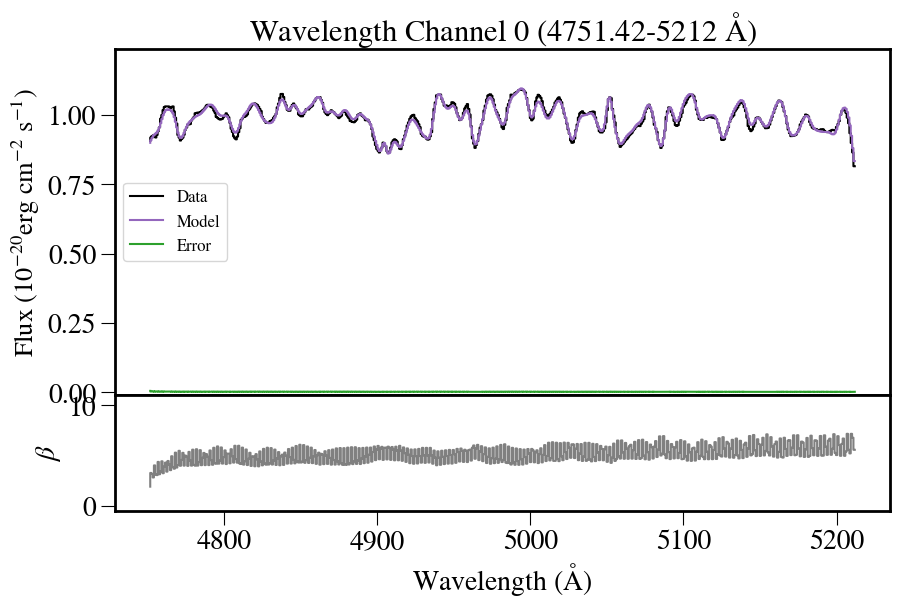

In [3]:
# wavelength channels range is 0-9
cube.mk_residual_plot(wv_channel=0,bin_id=0)

### 2.b Spectra with masked pixels will display a before and after beta plot

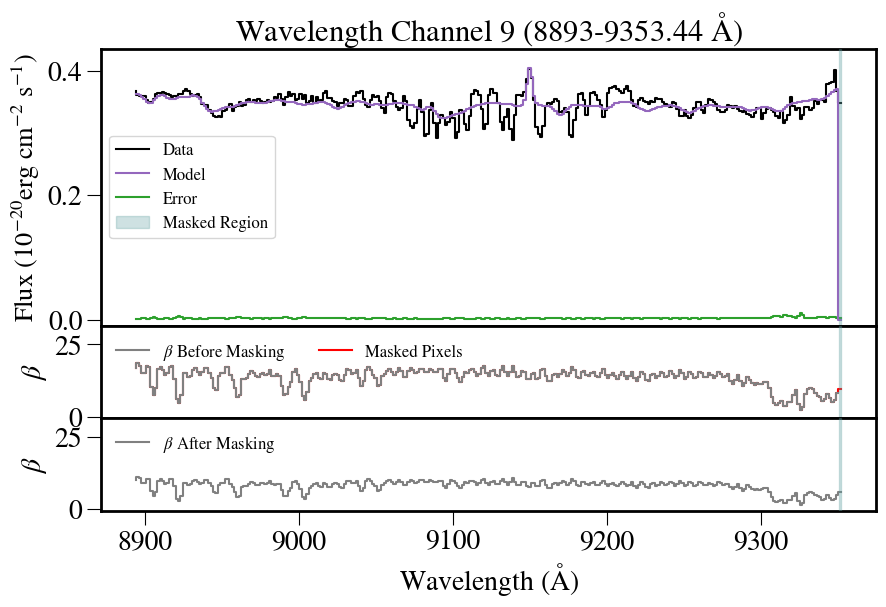

In [4]:
cube.mk_residual_plot(wv_channel=9,bin_id=15)

### 2.c Zoom in on the masked region using the zoom option

- Zoom input must be a list with two wavelengh values

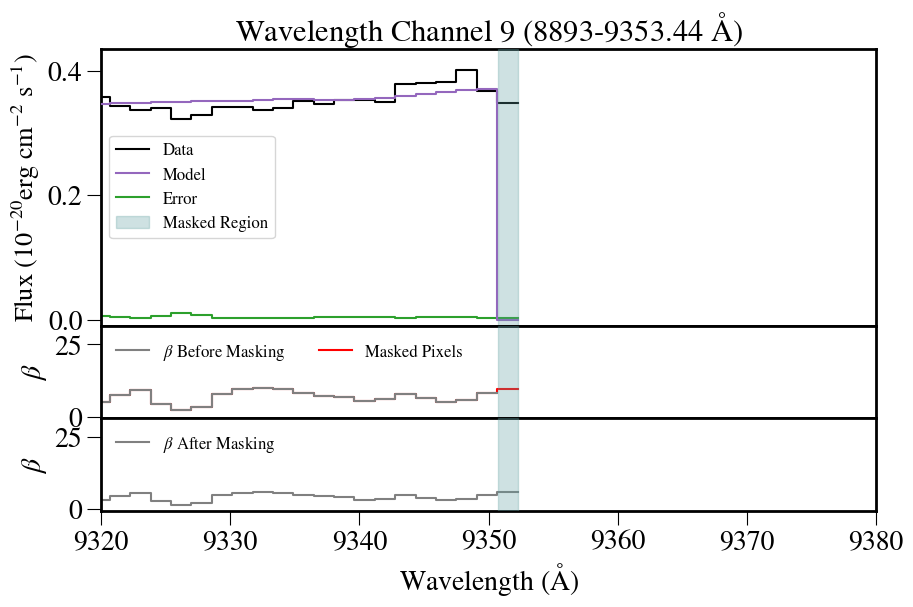

In [5]:
cube.mk_residual_plot(wv_channel=9,bin_id=15,zoom=[9320,9380])

## 3. View Histogram plots for each wavelength channel

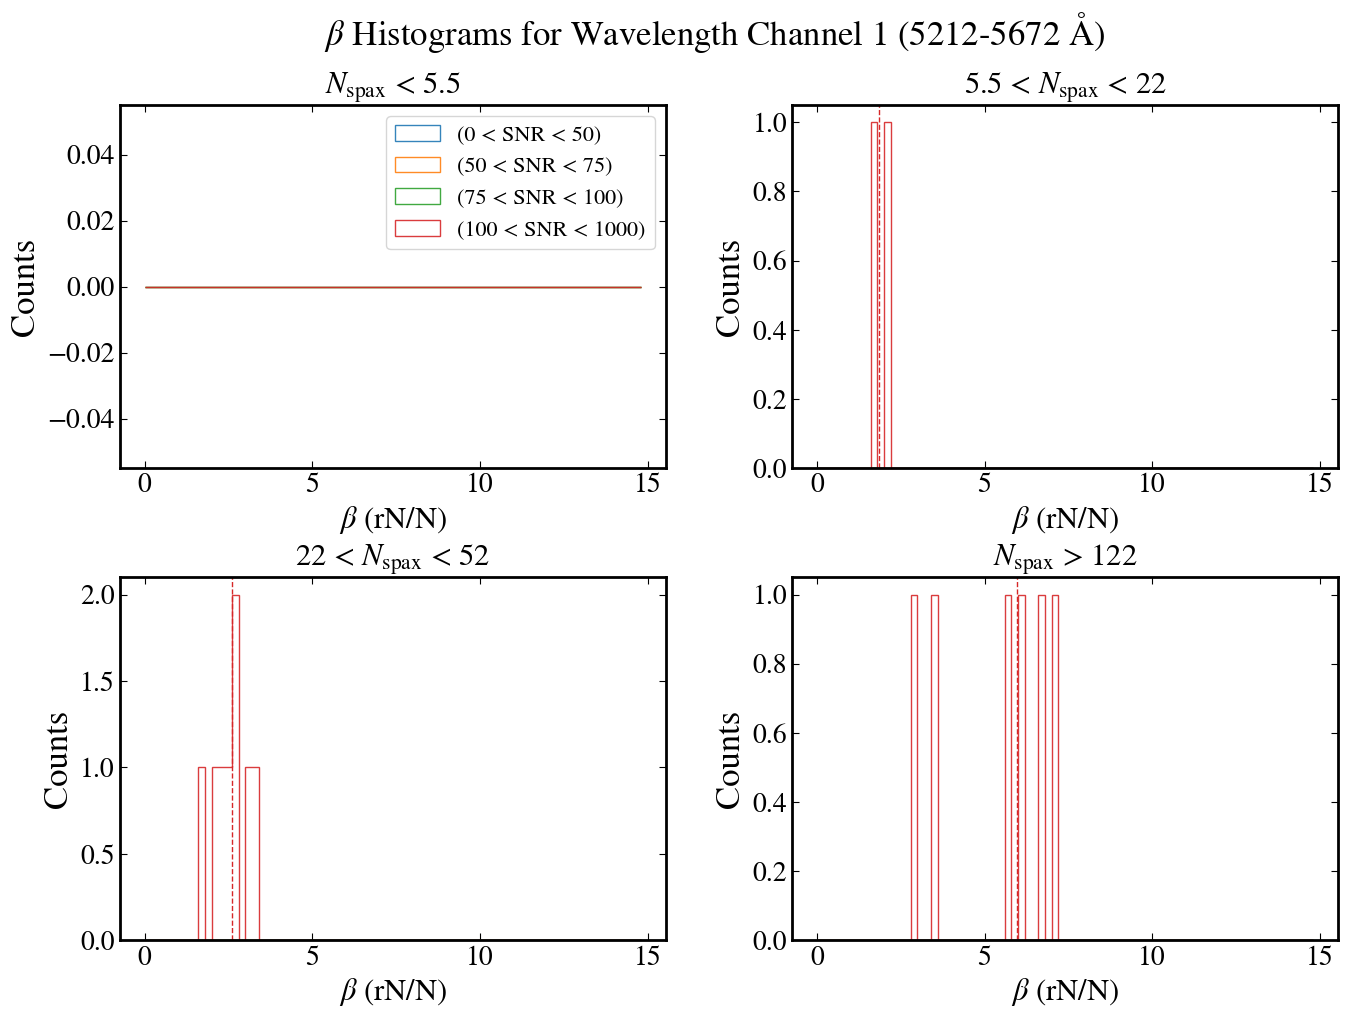

In [6]:
cube.mk_hist_plot(wv_channel=1)

## 4. Create beta table files

In [7]:
cube.write_beta_tables()

In [ ]:
def get_fitted_plot(bin_tot,beta_tot,wv_lim):
    bin_less50 = []
    bin_50_75 = []
    bin_75_100 = []
    bin_gr100 = []

    beta_less50 = []
    beta_50_75 = []
    beta_75_100 = []
    beta_gr100 = []

    for bin_SFR,beta_SFR in zip(bin_tot,beta_tot):
        if len(bin_SFR[0]) == 0:
            bin_less50.append(-999)
            beta_less50.append(-999)
        else:
            bin_less50.append(stats.mode(bin_SFR[0])[0][0])
            beta_less50.append(np.median(beta_SFR[0]))

        if len(bin_SFR[1]) == 0:
            bin_50_75.append(-999)
            beta_50_75.append(-999)
        else:
            bin_50_75.append(stats.mode(bin_SFR[1])[0][0])
            beta_50_75.append(np.median(beta_SFR[1]))

        if len(bin_SFR[2]) == 0:
            bin_75_100.append(-999)
            beta_75_100.append(-999)
        else:
            bin_75_100.append(stats.mode(bin_SFR[2])[0][0])
            beta_75_100.append(np.median(beta_SFR[2]))

        if len(bin_SFR[3]) == 0:
            pass
        else:
            bin_gr100.append(stats.mode(bin_SFR[3])[0][0])
            beta_gr100.append(np.median(beta_SFR[3]))

    bin_less50 = np.array(bin_less50)
    bin_50_75 = np.array(bin_50_75)
    bin_75_100 = np.array(bin_75_100)
    bin_gr100 = np.array(bin_gr100)

    beta_less50 = np.array(beta_less50)
    beta_50_75 = np.array(beta_50_75)
    beta_75_100 = np.array(beta_75_100)
    beta_gr100 = np.array(beta_gr100)

    bin_fit = np.concatenate((bin_less50[bin_less50 > -999],bin_50_75[bin_50_75 > -999],
                              bin_75_100[bin_75_100 > -999]))
    beta_fit = np.concatenate((beta_less50[beta_less50 > -999],beta_50_75[beta_50_75 > -999],
                              beta_75_100[beta_75_100 > -999]))

    # get parameters
    # fit data points usings Sarzi+2018 relationshiop
    popt_sarzi, pcov_sarzi = curve_fit(beta_func_quad, bin_fit, beta_fit)

    SNR_ranges = [[0,50],[50,75],[75,100],[100,1000]]

    plt.rcParams['figure.figsize'] = (8,6) 
    fig = plt.figure()
    plt.scatter(bin_less50[bin_less50 > -999],beta_less50[beta_less50 > -999],
                    label=r'{} < SNR < {}'.format(SNR_ranges[0][0],SNR_ranges[0][1]),marker='s')
    plt.scatter(bin_50_75[bin_50_75 > -999],beta_50_75[beta_50_75 > -999],
                    label=r'{} < SNR < {}'.format(SNR_ranges[1][0],SNR_ranges[1][1]),marker='o')       
    plt.scatter(bin_75_100[bin_75_100 > -999],beta_75_100[beta_75_100 > -999],
                    label=r'{} < SNR < {}'.format(SNR_ranges[2][0],SNR_ranges[2][1]),marker='^')
    plt.scatter(bin_gr100,beta_gr100,label=r'{} < SNR < {}'.format(
                    SNR_ranges[3][0],SNR_ranges[3][1]),marker='D')

    bin_all = np.concatenate((bin_less50,bin_50_75,bin_75_100,bin_gr100))
    beta_all = np.concatenate((beta_less50,beta_50_75,beta_75_100,beta_gr100))

    #plt.plot(bin_all,beta_func(bin_all,popt_garcia[0]),c='grey',ls='--',label='Garcia-Benito+2015')
    plt.plot(bin_all,beta_func_quad(bin_all,popt_sarzi[0],popt_sarzi[1]),c='k',ls='--',label='Sarzi+2018')

    plt.title('Fitted Parameters for $\lambda$ Range:{}-{} $\AA$'.format(
                    wv_lim[0],wv_lim[1]))

    plt.ylabel(r' Median $\beta$ (rN/N)')
    plt.xlabel('Mode $N_{spax}$')
    plt.xscale('log')
    plt.legend(fontsize='x-large',frameon=False); 
    plt.tick_params(axis='both', which='both',direction='in',top=True,right=True,length=5)
    plt.figtext(x=0.15, y=0.50,s='Parameter Fits\n',fontsize=14)
    text_str = 'a = {:.2f}, b = {:.2f}'.format(popt_sarzi[0],popt_sarzi[1])
    plt.figtext(x=0.15, y=0.49,s=text_str,fontsize=14)
    
    # create data table containting each median beta histogram distribution for a given S/N and N_spax size
    beta_table = Table([beta_less50[:3],beta_50_75[:3],beta_75_100[:3],
                        [popt_sarzi[0],-999,-999],[popt_sarzi[1],-999,-999]],
                  names=('S_N_0-50','S_N_50-75','S_N_75-100','param_fit_a','param_fit_b'))
    table_name =  '/Users/erickaguirre/Desktop/beta_corr_tables/beta_corr_' \
                  + str(wv_lim[0]) +'_' + str(wv_lim[1]) + '.dat'
    beta_table.write(table_name, format='ascii', overwrite=True)  
    
    plt.savefig('/Users/erickaguirre/Desktop/paper_plots/beta_correction_plots/beta_fit_'
                +str(wv_lim[0])+'_'+str(wv_lim[1])+'.pdf');

In [23]:
def get_betagood(bins,betas,SNRs,Nspax_range,SNR_ranges):
    
    # exclude outliers
    bin_good = bins[betas < 20]
    SNR_good = SNRs[betas < 20]
    beta_good = betas[betas < 20]
    
    # filter arrays given spaxel size range
    bin_filt = bin_good[(bin_good > Nspax_range[0]) & (bin_good < Nspax_range[1])]
    beta = beta_good[(bin_good > Nspax_range[0]) & (bin_good < Nspax_range[1])]
    SNR = SNR_good[(bin_good > Nspax_range[0]) & (bin_good < Nspax_range[1])]
    
    # filter arrays given S/N range
    bin_less50 = bin_filt[(SNR > SNR_ranges[0][0]) & (SNR < SNR_ranges[0][1])]
    bin_50_75 = bin_filt[(SNR > SNR_ranges[1][0]) & (SNR < SNR_ranges[1][1])]
    bin_75_100 = bin_filt[(SNR > SNR_ranges[2][0]) & (SNR < SNR_ranges[2][1])]
    bin_gr100 = bin_filt[(SNR > SNR_ranges[3][0]) & (SNR < SNR_ranges[3][1])]
    
    beta_less50 = beta[(SNR > SNR_ranges[0][0]) & (SNR < SNR_ranges[0][1])]
    beta_50_75 = beta[(SNR > SNR_ranges[1][0]) & (SNR < SNR_ranges[1][1])]
    beta_75_100 = beta[(SNR > SNR_ranges[2][0]) & (SNR < SNR_ranges[2][1])]
    beta_gr100 = beta[(SNR > SNR_ranges[3][0]) & (SNR < SNR_ranges[3][1])]
    
    bins_SNRs = [bin_less50,bin_50_75,bin_75_100,bin_gr100]
    betas_SNRs = [beta_less50,beta_50_75,beta_75_100,beta_gr100]

    return bins_SNRs,betas_SNRs


# def get_betaplots(bin1,beta1_arr,SNR1,bin2,beta2_arr,SNR2,bin3,beta3_arr,SNR3):
def get_betaplots(bin2,beta2_arr,SNR2,wv_lim):
    
    Nspax_ranges = [[0,5.5],[5.5,20],[20,50],[50,120]]
    SNR_ranges = [[0,50],[50,75],[75,100],[100,1000]]
    beta_bins = np.arange(0,15,0.2)
    
    plt.rcParams['figure.figsize'] = (16,12) 
    fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
    fig.tight_layout(pad=5.0)
    
    bin_tot = []
    beta_tot = []

    for ax,Nspax_range in zip(fig.get_axes(),Nspax_ranges):
        
        bins, betas = get_betagood(bin2,beta2_arr,SNR2,Nspax_range,SNR_ranges)
            
        bin_tot.append(bins)
        beta_tot.append(betas)
        
#         ax.hist(beta1_less100,bins=50,label=r'Range 1 (SNR < {}) ({}-{}$\AA$)'.format(snr_lim,wv_lims[0][0],
#                 wv_lims[0][1]),histtype='step',stacked=False,alpha=0.9,fill=False,color='tab:blue')
#         ax.hist(beta1_more100,bins=50,label=r'Range 1 (SNR < {}) ({}-{}$\AA$)'.format(snr_lim,wv_lims[0][0],
#                 wv_lims[0][1]),histtype='step',stacked=False,alpha=0.9,fill=False,ls='--',color='tab:blue') 
        
        for i in range(len(SNR_ranges)):
            ax.hist(betas[i],bins=beta_bins,label=r'({} < SNR < {})'.format(
                SNR_ranges[i][0],SNR_ranges[i][1]),histtype='step',
                stacked=False,alpha=0.9,fill=False)
            ax.tick_params(axis='both', which='both', direction='in',top=True,right=True,length=5)
            ax.set_xticks(np.arange(1,10))
        
        colors = ['tab:blue','tab:orange','tab:green','tab:red']
        for beta,color,bin_SNR in zip(betas,colors,bins):
            if np.isnan(np.median(beta)) == True:
                continue
            else:
                ax.axvline(np.median(beta),ls='--',c=color,lw=1)
        
#         ax.hist(beta3_less100,bins=50,label=r'Range 3 (SNR < {}) ({}-{}$\AA$)'.format(snr_lim,wv_lims[2][0],
#                 wv_lims[2][1]),histtype='step',stacked=False,alpha=0.9,fill=False,color='tab:gray') 
#         ax.hist(beta3_more100,bins=50,label=r'Range 3 (SNR < {}) ({}-{}$\AA$)'.format(snr_lim,wv_lims[2][0],
#                 wv_lims[2][1]),histtype='step',stacked=False,alpha=0.9,fill=False,ls='-.',color='tab:gray') 
                                               
#         ax.hist(beta2,bins=50,label=r'Range 2 ({}-{}$\AA$)'.format(wv_lims[1][0],wv_lims[1][1]),
#                                                       histtype='step',stacked=False,alpha=0.9,fill=False)
#         ax.hist(beta3,bins=50,label=r'Range 3 ({}-{}$\AA$)'.format(wv_lims[2][0],wv_lims[2][1]),
#                                                       histtype='step',stacked=False,alpha=0.9,fill=False)
        
        ax.set_xlim(0,10)
        ax.set_xlabel(r'$\beta$ (rN/N)')
        ax.set_ylabel('Counts')
        ax.set_title(r'{0} < $N_{{\mathrm{{spax}}}}$ < {1}'.format(Nspax_range[0],Nspax_range[1]))
    
    ax1.set_title(r'$N_{{ \mathrm{{spax}} }}$ < {0}'.format(Nspax_ranges[0][1]))
    ax1.legend(fontsize=16)
    ax4.set_title(r'$N_{{ \mathrm{{spax}} }}$ > {0}'.format(Nspax_ranges[3][0]))
    fig.suptitle(r'$\beta$ Histograms for $\lambda$ Range:{}-{} $\AA$'.format(
                    wv_lim[0],wv_lim[1]),fontsize=22)

    fig.savefig('/Users/erickaguirre/Desktop/paper_plots/beta_correction_plots/beta_hist_'
                +str(wv_lim[0])+'_'+str(wv_lim[1])+'.pdf');

    return bin_tot,beta_tot

In [136]:
N_arr = [3,9,9,9,6]
S_N = [22,70,80,120,5]

def get_beta(N_spx,S_N):
    
    SNR_ranges = np.array([[0,50],[50,75],[75,100],[100,1000]])
    median_beta_hist = [[3,1.3388808  ], [9,1.458873,1.5007526,1.4971246], [25,1.6623335]]
    
    # Quadratic error correction (Sarzi et al. 2018)
    # parameter fits for NGC 4030
    a,b = 0.51, 0.66

    if N_spx == median_beta_hist[0][0]:
        if (S_N >  SNR_ranges[0][0]) & (S_N <  SNR_ranges[0][1]):
            return median_beta_hist[0][1]

        else:
            # beta from Sarzi et al. relation (2018)
            beta = beta_func_quad(N_spx,a,b)
            return beta

    elif N_spx == median_beta_hist[1][0]:

        for k in range(len(SNR_ranges)):
            if (S_N >  SNR_ranges[k][0]) & (S_N <  SNR_ranges[k][1]):
                if k == 3:
                    # beta from Sarzi et al. relation (2018)
                    beta = beta_func_quad(N_spx,a,b)
                    return beta

                else:
                    return median_beta_hist[j][k]

    elif N_spx == median_beta_hist[2][0]:

        if (S_N >  SNR_ranges[2][0]) & (S_N <  SNR_ranges[2][1]):
            return median_beta_hist[2][1]


        else:
            # beta from Sarzi et al. relation (2018)
            beta = beta_func_quad(N_spx,a,b)
            return beta

    else: 
        # beta from Sarzi et al. relation (2018)
        beta = beta_func_quad(N_spx,a,b)
        return beta

In [75]:
N_arr = [3,3,6,9,9,4,25,25,6,9,3]
S_N = [22,70,80,120,5,35,368,88,113,55,32,78]

for i in range(len(N_arr)):
    beta = get_beta(N_arr[i],S_N[i])
    print(N_arr[i],S_N[i],beta)

Using median beta for Nspax size: 3
  using median beta for SNR range: 0 - 50
3 22 1.3388808
Using median beta for Nspax size: 3
  using sarzi relation for S/N: 70
3 70 1.312942941401922
Using sarzi relation for Nspax size: 6
6 80 1.4321877261690499
Using median beta for Nspax size: 9
  using sarzi relation for SNR range: 100 - 1000
9 120 1.4944757039271168
Using median beta for Nspax size: 9
  using median beta for SNR range: 0 - 50
9 5 9
Using sarzi relation for Nspax size: 4
4 35 1.3648651829024145
  using sarzi relation for S/N: 368
25 368 1.6361984531611906
  using median beta for SNR range: 75 - 100
25 88 1.6623335
Using sarzi relation for Nspax size: 6
6 113 1.4321877261690499
Using median beta for Nspax size: 9
  using median beta for SNR range: 50 - 75
9 55 1.458873
Using median beta for Nspax size: 3
  using median beta for SNR range: 0 - 50
3 32 1.3388808


Model Parameter Fits
--------------------
(Garcia+2015) beta(N) = 1 + 0.50*log10(N_spaxel)
(Sarzi+2018)  beta(N) = 1 + 0.51*log10(N_spaxel)^0.66

For Nspax = 25 and SNR_bin > 100
----------------------------------
(Median Beta) beta = 1.77
(Garcia+2015) beta = 1.70
(Sarzi+2018)  beta = 1.64

For Nspax = 100 and SNR_bin > 100
----------------------------------
(Median Beta) beta = 2.49
(Garcia+2015) beta = 2.01
(Sarzi+2018)  beta = 1.81


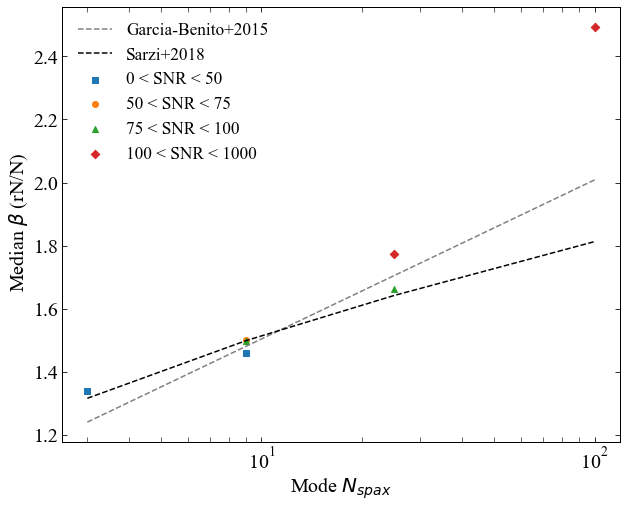

In [12]:
SNR_ranges = [[0,50],[50,75],[75,100],[100,1000]]

plt.rcParams['figure.figsize'] = (10,8) 
plt.scatter(bin_less50,beta_less50,label=r'{} < SNR < {}'.format(
                SNR_ranges[0][0],SNR_ranges[0][1]),marker='s')
plt.scatter(bin_50_75,beta_50_75,label=r'{} < SNR < {}'.format(
                SNR_ranges[1][0],SNR_ranges[1][1]),marker='o')       
plt.scatter(bin_75_100,beta_75_100,label=r'{} < SNR < {}'.format(
                SNR_ranges[2][0],SNR_ranges[2][1]),marker='^')
plt.scatter(bin_gr100,beta_gr100,label=r'{} < SNR < {}'.format(
                SNR_ranges[3][0],SNR_ranges[3][1]),marker='D')

bin_all = np.concatenate((bin_less50,bin_50_75,bin_75_100,bin_gr100))
beta_all = np.concatenate((beta_less50,beta_50_75,beta_75_100,beta_gr100))

plt.plot(bin_all,beta_func(bin_all,popt_garcia[0]),c='grey',ls='--',label='Garcia-Benito+2015')
plt.plot(bin_all,beta_func_quad(bin_all,popt_sarzi[0],popt_sarzi[1]),c='k',ls='--',label='Sarzi+2018')

plt.ylabel(r' Median $\beta$ (rN/N)')
plt.xlabel('Mode $N_{spax}$')
plt.xscale('log')
plt.legend(fontsize='xx-large',frameon=False); 
plt.tick_params(axis='both', which='both',direction='in',top=True,right=True,length=5)
plt.savefig('/Users/erickaguirre/Desktop/beta_correction_plots/med_beta_vs_Nspax.pdf')

print('Model Parameter Fits')
print('--------------------')
print('(Garcia+2015) beta(N) = 1 + {:.2f}*log10(N_spaxel)'.format(popt_garcia[0]));
print('(Sarzi+2018)  beta(N) = 1 + {:.2f}*log10(N_spaxel)^{:.2f}\n'.format(popt_sarzi[0],popt_sarzi[1]))

print('For Nspax = 25 and SNR_bin > 100')
print('----------------------------------')
print('(Median Beta) beta = {:.2f}'.format(beta_gr100[0]))
print('(Garcia+2015) beta = {:.2f}'.format(beta_func(25,popt_garcia[0])))
print('(Sarzi+2018)  beta = {:.2f}\n'.format(beta_func_quad(25,popt_sarzi[0],popt_sarzi[1])))

print('For Nspax = 100 and SNR_bin > 100')
print('----------------------------------')
print('(Median Beta) beta = {:.2f}'.format(beta_gr100[1]))
print('(Garcia+2015) beta = {:.2f}'.format(beta_func(100,popt_garcia[0])))
print('(Sarzi+2018)  beta = {:.2f}'.format(beta_func_quad(100,popt_sarzi[0],popt_sarzi[1])))

In [43]:
def get_fitted_plot(bin_tot,beta_tot,wv_lim):
    bin_less50 = []
    bin_50_75 = []
    bin_75_100 = []
    bin_gr100 = []

    beta_less50 = []
    beta_50_75 = []
    beta_75_100 = []
    beta_gr100 = []

    for bin_SFR,beta_SFR in zip(bin_tot,beta_tot):
        if len(bin_SFR[0]) == 0:
            bin_less50.append(-999)
            beta_less50.append(-999)
        else:
            bin_less50.append(stats.mode(bin_SFR[0])[0][0])
            beta_less50.append(np.median(beta_SFR[0]))

        if len(bin_SFR[1]) == 0:
            bin_50_75.append(-999)
            beta_50_75.append(-999)
        else:
            bin_50_75.append(stats.mode(bin_SFR[1])[0][0])
            beta_50_75.append(np.median(beta_SFR[1]))

        if len(bin_SFR[2]) == 0:
            bin_75_100.append(-999)
            beta_75_100.append(-999)
        else:
            bin_75_100.append(stats.mode(bin_SFR[2])[0][0])
            beta_75_100.append(np.median(beta_SFR[2]))

        if len(bin_SFR[3]) == 0:
            pass
        else:
            bin_gr100.append(stats.mode(bin_SFR[3])[0][0])
            beta_gr100.append(np.median(beta_SFR[3]))

    bin_less50 = np.array(bin_less50)
    bin_50_75 = np.array(bin_50_75)
    bin_75_100 = np.array(bin_75_100)
    bin_gr100 = np.array(bin_gr100)

    beta_less50 = np.array(beta_less50)
    beta_50_75 = np.array(beta_50_75)
    beta_75_100 = np.array(beta_75_100)
    beta_gr100 = np.array(beta_gr100)

    bin_fit = np.concatenate((bin_less50[bin_less50 > -999],bin_50_75[bin_50_75 > -999],
                              bin_75_100[bin_75_100 > -999]))
    beta_fit = np.concatenate((beta_less50[beta_less50 > -999],beta_50_75[beta_50_75 > -999],
                              beta_75_100[beta_75_100 > -999]))

    # get parameters
    # fit data points usings Sarzi+2018 relationshiop
    popt_sarzi, pcov_sarzi = curve_fit(beta_func_quad, bin_fit, beta_fit)

    SNR_ranges = [[0,50],[50,75],[75,100],[100,1000]]

    plt.rcParams['figure.figsize'] = (8,6) 
    fig = plt.figure()
    plt.scatter(bin_less50[bin_less50 > -999],beta_less50[beta_less50 > -999],
                    label=r'{} < SNR < {}'.format(SNR_ranges[0][0],SNR_ranges[0][1]),marker='s')
    plt.scatter(bin_50_75[bin_50_75 > -999],beta_50_75[beta_50_75 > -999],
                    label=r'{} < SNR < {}'.format(SNR_ranges[1][0],SNR_ranges[1][1]),marker='o')       
    plt.scatter(bin_75_100[bin_75_100 > -999],beta_75_100[beta_75_100 > -999],
                    label=r'{} < SNR < {}'.format(SNR_ranges[2][0],SNR_ranges[2][1]),marker='^')
    plt.scatter(bin_gr100,beta_gr100,label=r'{} < SNR < {}'.format(
                    SNR_ranges[3][0],SNR_ranges[3][1]),marker='D')

    bin_all = np.concatenate((bin_less50,bin_50_75,bin_75_100,bin_gr100))
    beta_all = np.concatenate((beta_less50,beta_50_75,beta_75_100,beta_gr100))

    #plt.plot(bin_all,beta_func(bin_all,popt_garcia[0]),c='grey',ls='--',label='Garcia-Benito+2015')
    plt.plot(bin_all,beta_func_quad(bin_all,popt_sarzi[0],popt_sarzi[1]),c='k',ls='--',label='Sarzi+2018')

    plt.title('Fitted Parameters for $\lambda$ Range:{}-{} $\AA$'.format(
                    wv_lim[0],wv_lim[1]))

    plt.ylabel(r' Median $\beta$ (rN/N)')
    plt.xlabel('Mode $N_{spax}$')
    plt.xscale('log')
    plt.legend(fontsize='x-large',frameon=False); 
    plt.tick_params(axis='both', which='both',direction='in',top=True,right=True,length=5)
    plt.figtext(x=0.15, y=0.50,s='Parameter Fits\n',fontsize=14)
    text_str = 'a = {:.2f}, b = {:.2f}'.format(popt_sarzi[0],popt_sarzi[1])
    plt.figtext(x=0.15, y=0.49,s=text_str,fontsize=14)
    
    # create data table containting each median beta histogram distribution for a given S/N and N_spax size
    beta_table = Table([beta_less50[:3],beta_50_75[:3],beta_75_100[:3],
                        [popt_sarzi[0],-999,-999],[popt_sarzi[1],-999,-999]],
                  names=('S_N_0-50','S_N_50-75','S_N_75-100','param_fit_a','param_fit_b'))
    table_name =  '/Users/erickaguirre/Desktop/beta_corr_tables/beta_corr_' \
                  + str(wv_lim[0]) +'_' + str(wv_lim[1]) + '.dat'
    beta_table.write(table_name, format='ascii', overwrite=True)  
    
    plt.savefig('/Users/erickaguirre/Desktop/paper_plots/beta_correction_plots/beta_fit_'
                +str(wv_lim[0])+'_'+str(wv_lim[1])+'.pdf');

/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_24203/2557953347.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  bin_less50.append(stats.mode(bin_SFR[0])[0][0])
/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_24203/2557953347.py:24: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` 

/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_24203/2557953347.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  bin_less50.append(stats.mode(bin_SFR[0])[0][0])
/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_24203/2557953347.py:24: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` 

/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_24203/2557953347.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  bin_less50.append(stats.mode(bin_SFR[0])[0][0])
/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_24203/2557953347.py:24: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` 

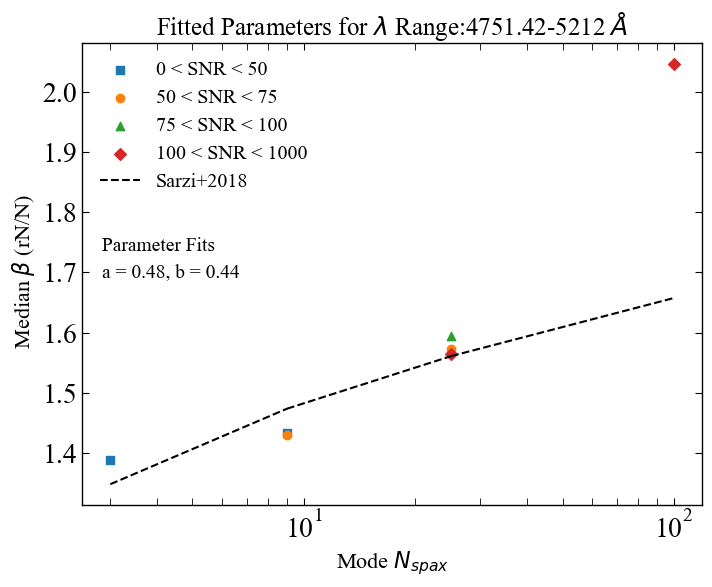

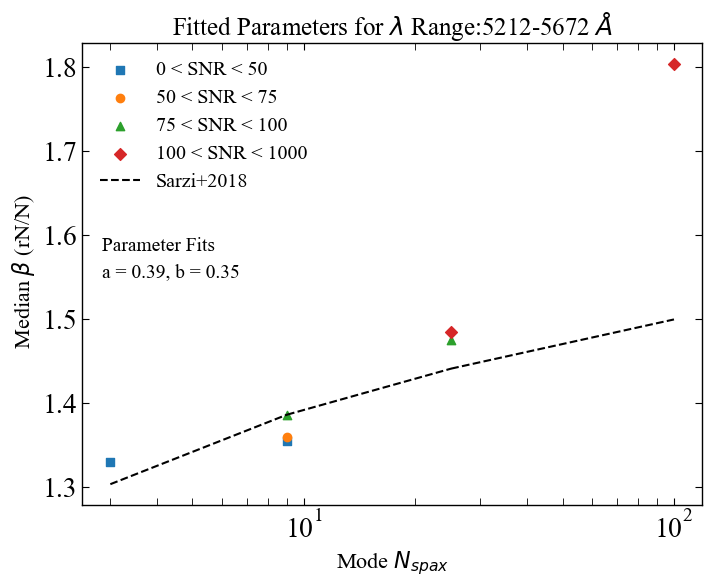

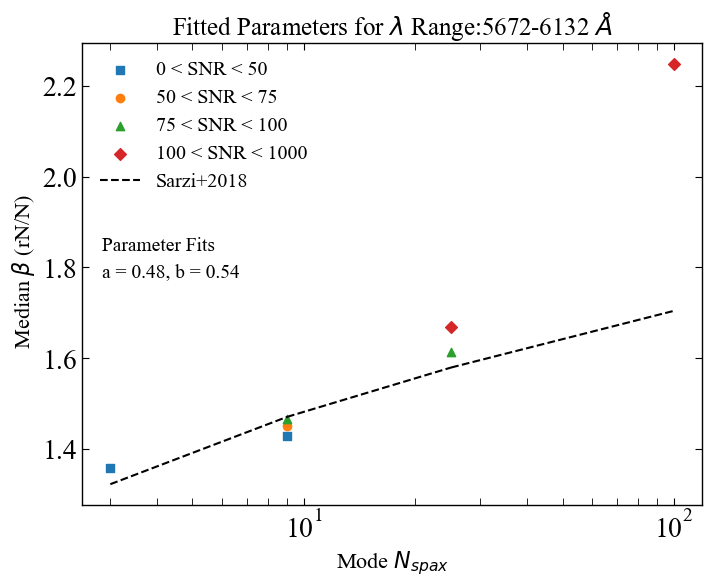

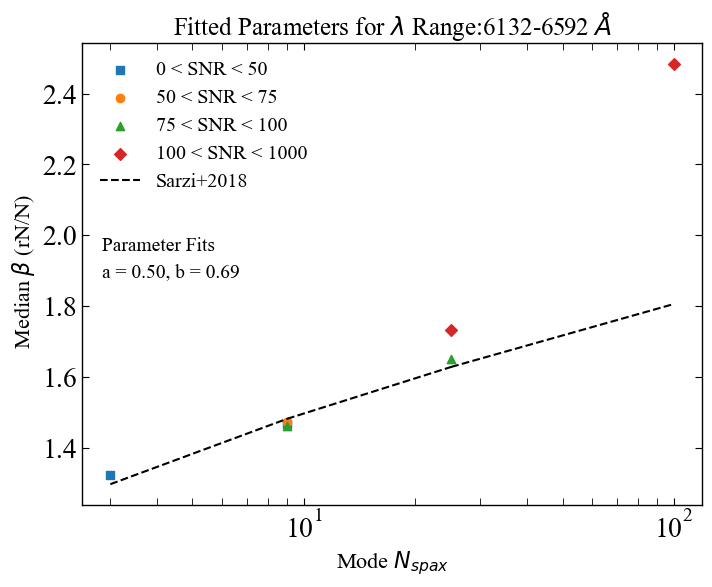

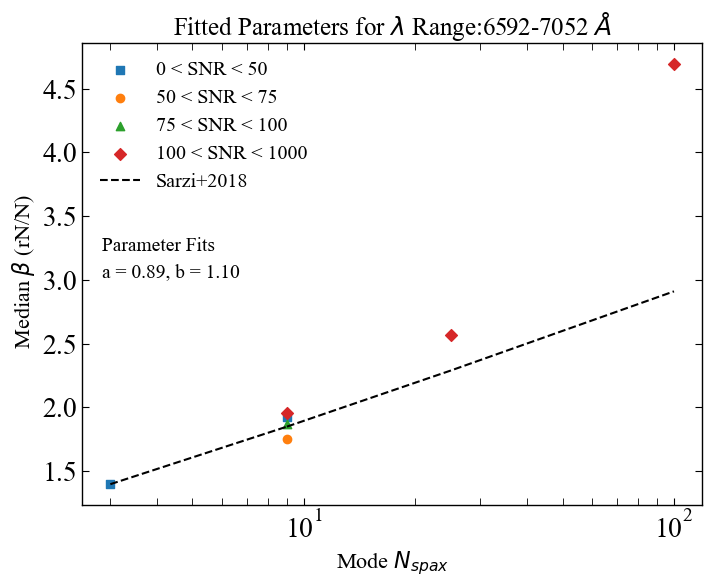

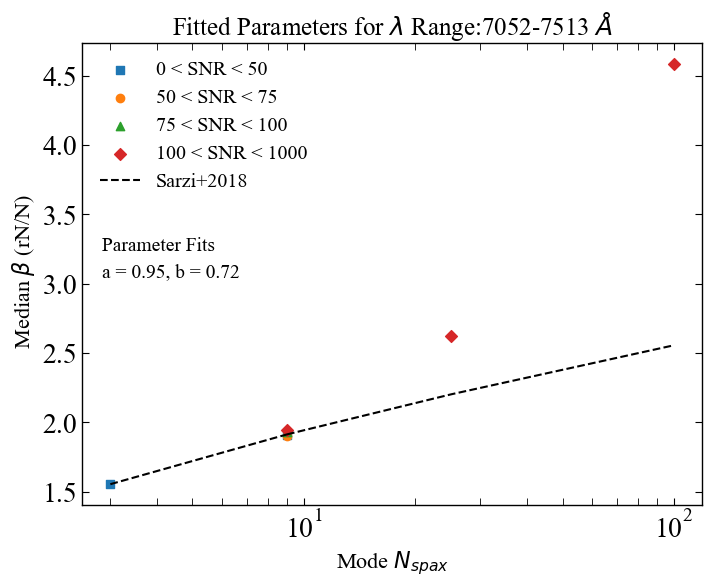

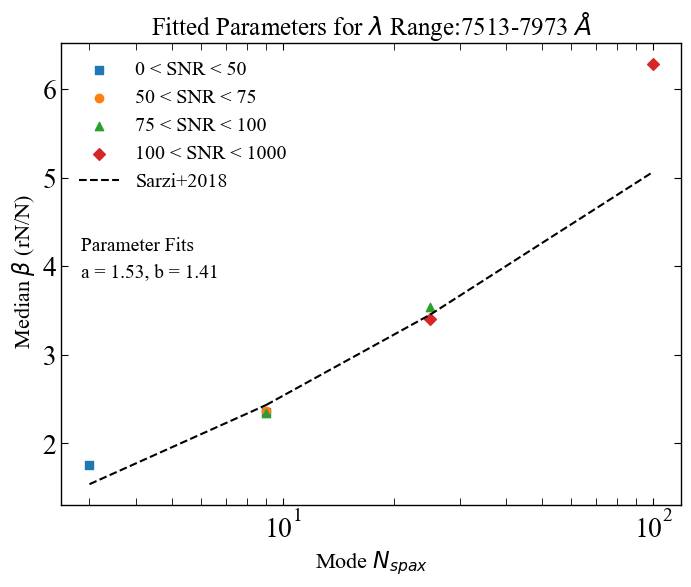

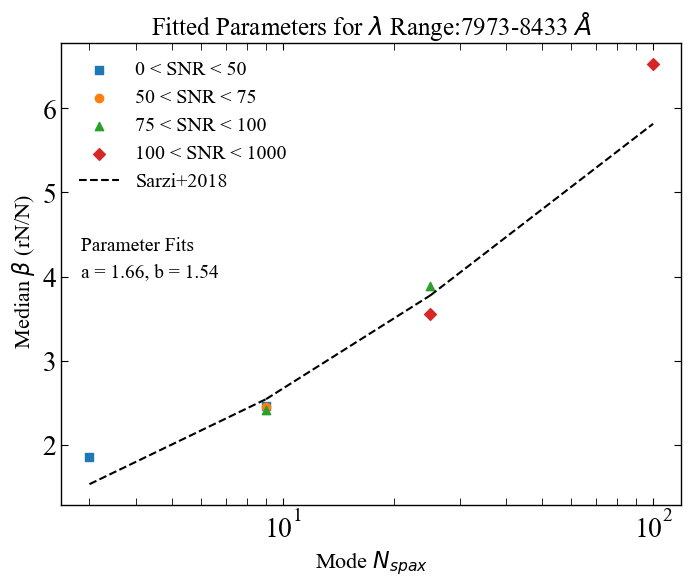

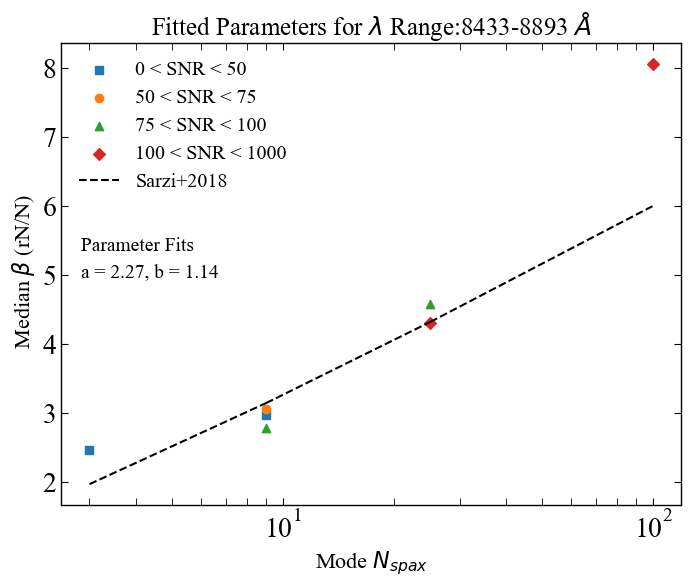

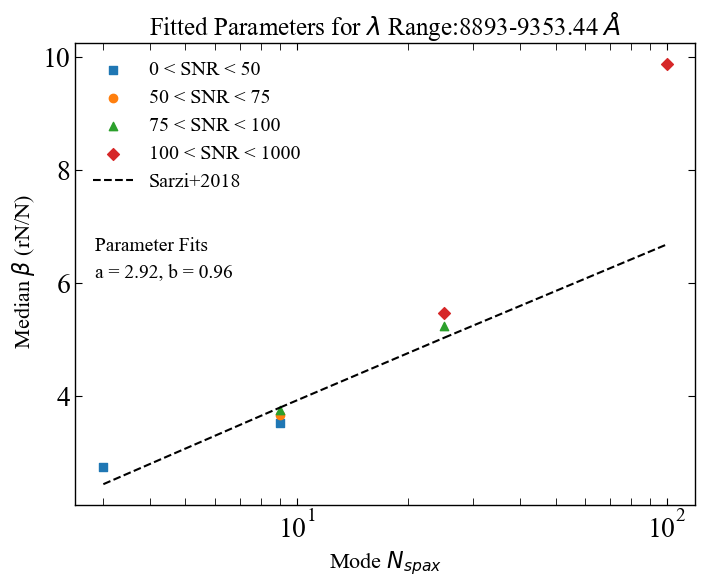

In [44]:
wv_lims = [[4751.42,5212],[5212,5672],[5672,6132],[6132,6592],
           [6592,7052],[7052,7513],[7513,7973],[7973,8433],[8433,8893],[8893,9353.44]]

get_fitted_plot(bin_tot0,beta_tot0,wv_lims[0])
get_fitted_plot(bin_tot1,beta_tot1,wv_lims[1])
get_fitted_plot(bin_tot2,beta_tot2,wv_lims[2])
get_fitted_plot(bin_tot3,beta_tot3,wv_lims[3])
get_fitted_plot(bin_tot4,beta_tot4,wv_lims[4])
get_fitted_plot(bin_tot5,beta_tot5,wv_lims[5])
get_fitted_plot(bin_tot6,beta_tot6,wv_lims[6])
get_fitted_plot(bin_tot7,beta_tot7,wv_lims[7])
get_fitted_plot(bin_tot8,beta_tot8,wv_lims[8])
get_fitted_plot(bin_tot9,beta_tot9,wv_lims[9])

In [15]:
# specificy violin plot colors from plt.violinplot obj
# ex) violinplots = plt.violinplot(x)
def get_violin_colors(violinplot_obj,c_indx):
    colors = ['tab:blue','tab:orange','tab:green','tab:red']
    
    for partname in ('cbars','cmins','cmaxes','cmedians','bodies'):
        violin = violinplot_obj[partname]
        if partname == 'bodies':
            for vp in violin:
                vp.set_color(colors[c_indx])
                vp.set_facecolor(colors[c_indx])
                vp.set_edgecolor(colors[c_indx])
                vp.set_alpha(0.2)
                vp.set_label('uhh')
                
        else:
            violin.set_edgecolor(colors[c_indx])
            violin.set_linewidth(2)

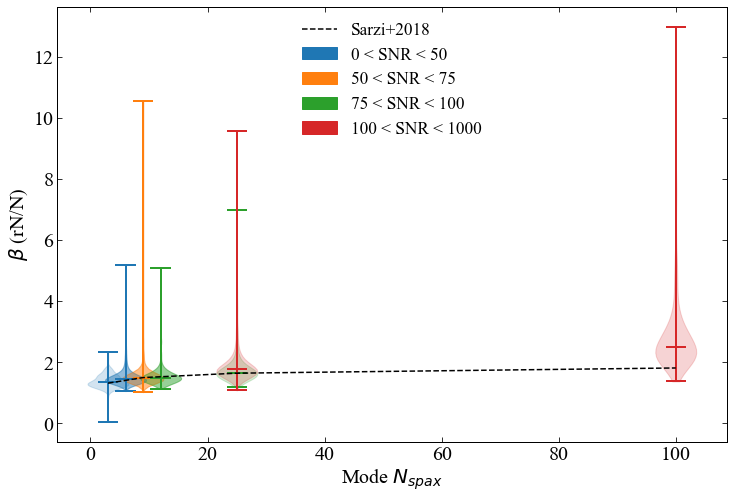

In [38]:
SNR_ranges = [[0,50],[50,75],[75,100],[100,1000]]
bin_uniq = np.unique(bin_all)

x_offset = [-3,0,3]
plt.rcParams['figure.figsize'] = (12,8) 

colors = ['tab:blue','tab:orange','tab:green','tab:red']
for j in range(len(beta_tot)):
    for i in range(len(beta_tot)):
        if len(beta_tot[i][j]) == 0:
            continue
        else:
            if i == 1:
                for k in range(len(beta_tot[i])-1):
                    violinplots = plt.violinplot(beta_tot[i][k],positions=[bin_uniq[i]+x_offset[k]],
                                                 showmedians=True,widths=7)
                    get_violin_colors(violinplots,k)
                continue
            
            else:
                violinplots = plt.violinplot(beta_tot[i][j],positions=[bin_uniq[i]],showmedians=True,
                                             widths=7)
                get_violin_colors(violinplots,j)

plt.plot(bin_all,beta_func_quad(bin_all,popt_sarzi[0],popt_sarzi[1]),c='k',ls='--',label='Sarzi+2018')
plt.tick_params(axis='both', which='both',direction='in',top=True,right=True,length=5)
plt.ylabel(r'$\beta$ (rN/N)')
plt.xlabel('Mode $N_{spax}$');

colors = ['tab:blue','tab:orange','tab:green','tab:red']
color_patches = []
color_patches.append(plt.Line2D([],[],color='k', ls="--",label='Sarzi+2018'))

for i in range(len(SNR_ranges)):
    SNR_str = ('{} < SNR < {}'.format(SNR_ranges[i][0],SNR_ranges[i][1]))
    c_patch = mpatches.Patch(color=colors[i], label= SNR_str)
    color_patches.append(c_patch)
    
plt.legend(handles=color_patches,fontsize='xx-large',loc='upper center',frameon=False)
plt.savefig('/Users/erickaguirre/Desktop/beta_correction_plots/beta_violin_plots.pdf'); 